# Retrieve tables with date conversion
## Example National accounts
The tables for national accounts have the characteristic that they have the same structure but different frequency. Then we can easily use the same query, and post it against different tables' metadata. to retrieve numbers
Main macroeconomic parameters:
- [09189](https://www.ssb.no/statbank/table/09189) - annually
- [09190](https://www.ssb.no/statbank/table/09190) - quarterly
- [11721](https://www.ssb.no/statbank/table/11721) - monthly



In [1]:
# Here we import various packages

import requests
import pandas as pd
from pyjstat import pyjstat # pyjstat is for processing JSON-stat


URL to the table's metadata in PxWebApi, whre we can post the queries

In [2]:
tabid = "11721" # try to run with id for both year (09189), quarter (09190) and month (11721)
lang = "en" # we can choose "one"
url1 = "https://data.ssb.no/api/v0/" + lang + "/table/" + tabid;

We ask for annual volume change for GDP and GDP Mainland Norway for the period 2010-2029 using "filter": "all". API query formulated as JSON.

In [3]:
query1 = {
  "query": [
    {
      "code": "Makrost",
      "selection": {
        "filter": "item",
        "values": [
          "bnpb.nr23_9",
          "bnpb.nr23_9fn"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "Volum"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "all",
        "values": [
         "201*",
          "202*"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}

Generell funksjon for å identifisere frekvens slik at vi kan konvertere til datoformat og sette [**Pandas PeriodIndex**](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-span-representation)

In [4]:
#funksjon for frequencies
def dateConv(dataframe):
    frekvens, frek_no, frek_en, fmt = findFrequency(dataframe)
    setPeriodIndex(frekvens, frek_no, frek_en, fmt, dataframe)
    
def findFrequency(dataframe):
    frekvenser = ['måned', 'kvartal', 'uke', 'år', 'year', 'quarter', 'month', 'week']
    frek_no = '' # SSB unfortunately uses Norwegian frequency codes:  U - week etc.
    frek_en = '' # English frequency code
    fmt = '' # python date format
    for w in frekvenser:
        if w in dataframe.columns:
            if w in ['måned', 'month']:
                frek_no = 'M'
                frek_en = 'M'
                fmt = '%YM%m'
            elif w in ['kvartal', 'quarter']:
                frek_no = 'K'
                frek_en = 'Q'
            elif w in ['uke', 'week']:
                frek_no = 'U';
                frek_en = 'W'
                fmt = '%YW%W-%w'
            else:
                frek_no = ''
                frek_en = 'A'
            return w, frek_no, frek_en, fmt
    
        
def setPeriodIndex(frekvens, frek_no, freq_en, fmt, df):
    if frekvens in ['kvartal', 'quarter']:
        # replaces K with Q, converts to date format and sets the frequency to Panda's PeriodIndex
        df.index = pd.PeriodIndex(pd.to_datetime(df[frekvens].str.replace(frek_no, freq_en), errors='coerce'), freq='Q-DEC')
    elif frekvens in ['uke', 'week']:
        df.index = pd.PeriodIndex(pd.to_datetime(df[frekvens].str.replace(frek_no, freq_en).add('-0'), format= fmt, errors='coerce'), freq='W-MON')
    else:
        df.index =  pd.PeriodIndex(pd.to_datetime(df[frekvens], format= fmt, errors='coerce'), freq=freq_en)



Here we post the query

In [5]:
res1 = requests.post(url1, json=query1)

Reading the result using the pyjstat library

In [6]:
ds1 = pyjstat.Dataset.read(res1.text)

Writes the result to a Pandas dataframe

In [7]:
df1 = ds1.write('dataframe')

In [8]:
df1.head(7)

,macroeconomic indicator,contents,month,value
0,"Gross domestic product, market values",Change in volume from the same month in the pr...,2016M01,NaN
1,"Gross domestic product, market values",Change in volume from the same month in the pr...,2016M02,NaN
2,"Gross domestic product, market values",Change in volume from the same month in the pr...,2016M03,NaN
3,"Gross domestic product, market values",Change in volume from the same month in the pr...,2016M04,NaN
4,"Gross domestic product, market values",Change in volume from the same month in the pr...,2016M05,NaN
5,"Gross domestic product, market values",Change in volume from the same month in the pr...,2016M06,NaN
6,"Gross domestic product, market values",Change in volume from the same month in the pr...,2016M07,NaN


Calls the function dateConv which converts to date.
Make a conversion from category to date format. This is then set as Panda's PeriodIndex

In [9]:
dateConv(df1)

Pandas PeriodIndex

In [10]:
df1.index

PeriodIndex(['2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
             '2016-07', '2016-08', '2016-09', '2016-10',
             ...
             '2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05',
             '2024-06', '2024-07', '2024-08', '2024-09'],
            dtype='period[M]', name='month', length=210)

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 210 entries, 2016-01 to 2024-09
Freq: M
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   macroeconomic indicator  210 non-null    object 
 1   contents                 210 non-null    object 
 2   month                    210 non-null    object 
 3   value                    186 non-null    float64
dtypes: float64(1), object(3)
memory usage: 8.2+ KB


Plot using Pandas groupby - gir two charts

macroeconomic indicator
Gross domestic product Mainland Norway, market values    Axes(0.125,0.11;0.775x0.77)
Gross domestic product, market values                    Axes(0.125,0.11;0.775x0.77)
dtype: object

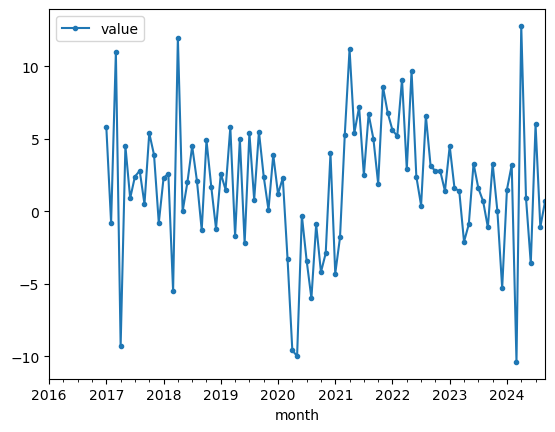

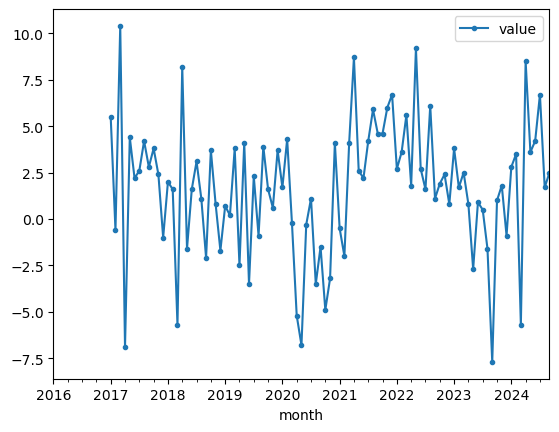

In [12]:
df1.groupby('macroeconomic indicator').plot( use_index=True, y='value', marker="o", markersize=3)

### pivot dataset in order to get one chart

In [13]:
df2 = df1.pivot(columns = 'macroeconomic indicator', values='value')

Increases size and sets SSB colors

<Axes: title={'center': 'GDP annual volume change in %'}, xlabel='month'>

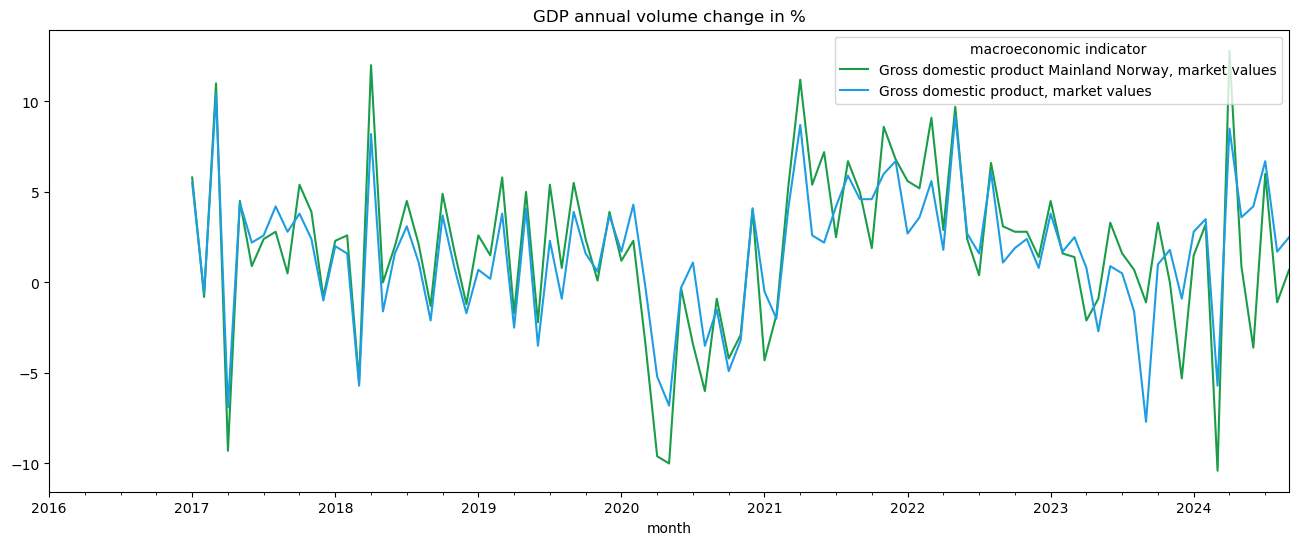

In [14]:
df2.plot(figsize=(16, 6), color=['#1a9d49', '#1d9de2'], title="GDP annual volume change in %")

In [15]:
df2.tail()

macroeconomic indicator,"Gross domestic product Mainland Norway, market values","Gross domestic product, market values"
month,,
2024-05,0.9,3.6
2024-06,-3.6,4.2
2024-07,6.0,6.7
2024-08,-1.1,1.7
2024-09,0.7,2.5


## Get metadata

In [16]:
print(ds1)

Dataset({'version': '2.0', 'class': 'dataset', 'label': '11721: Final expenditure and gross domestic product, by macroeconomic indicator, contents and month', 'source': 'Statistics Norway', 'updated': '2024-11-29T07:00:00Z', 'note': ['Gross domestic product Mainland Norway, basic values measured in current prices were updated 09 April 2022 for the period 2021M01-2022M02.', 'Errors in seasonally adjusted figures were corrected on November 29, 2024 at 11:35 a.m.', '.. = Data not available. Figures have not been entered into our databases or are too unreliable to be published.'], 'role': OrderedDict({'time': ['Tid'], 'metric': ['ContentsCode']}), 'id': ['Makrost', 'ContentsCode', 'Tid'], 'size': [2, 1, 105], 'dimension': OrderedDict({'Makrost': OrderedDict({'label': 'macroeconomic indicator', 'category': OrderedDict({'index': OrderedDict({'bnpb.nr23_9': 0, 'bnpb.nr23_9fn': 1}), 'label': OrderedDict({'bnpb.nr23_9': 'Gross domestic product, market values', 'bnpb.nr23_9fn': 'Gross domestic p

In [17]:
dataset = ds1

In [18]:
tittel = dataset['label']
print(tittel)

11721: Final expenditure and gross domestic product, by macroeconomic indicator, contents and month


In [19]:
last_update = dataset['updated']
print(last_update)

2024-11-29T07:00:00Z


In [20]:
source = dataset['source']
print(source)

Statistics Norway


In [21]:
ds_roles = dataset['role']
print(ds_roles)

OrderedDict({'time': ['Tid'], 'metric': ['ContentsCode']})


In [22]:
ds_id = dataset['extension']['px']['tableid']
print(ds_id)

11721


In [23]:
ds_shorttit = dataset['extension']['px']['contents']
print(ds_shorttit)

11721: Final expenditure and gross domestic product,


check for footnote

In [24]:
if 'note' in dataset:
    ds_note = dataset['note']
    print(ds_note)

['Gross domestic product Mainland Norway, basic values measured in current prices were updated 09 April 2022 for the period 2021M01-2022M02.', 'Errors in seasonally adjusted figures were corrected on November 29, 2024 at 11:35 a.m.', '.. = Data not available. Figures have not been entered into our databases or are too unreliable to be published.']


In [25]:
import re

def split_note(text_list):
    """
    Split text and reutrn separate lists 
    """
    # Look for : " or ' - comma space - " or ' 
    split_pattern = r'(?:"|\')\s*(?:"|\')'
    
    # Make list for all notes
    list_of_lists = []

    for text in text_list:
        parts_of_text = []
        
        # split text by pattern above
        raw_parts = re.split(split_pattern, text)
                      
        # Go through each part
        for part in raw_parts:
            # Strip space in begin and end
            cleaned_part = part.strip()
            
            if cleaned_part:
                # Append text in list
                parts_of_text.append(cleaned_part)
        
        # Appand parts to main list
        list_of_lists.append(parts_of_text)
    

    return list_of_lists

In [26]:
noter = split_note(ds_note)
print(noter)

[['Gross domestic product Mainland Norway, basic values measured in current prices were updated 09 April 2022 for the period 2021M01-2022M02.'], ['Errors in seasonally adjusted figures were corrected on November 29, 2024 at 11:35 a.m.'], ['.. = Data not available. Figures have not been entered into our databases or are too unreliable to be published.']]


In [27]:
print("Result: Text was split into these parts:")
for i, sublist in enumerate(noter, 1):
    print(f"\nFootnote {i}:")
    for j, part in enumerate(sublist, 1):
        print(f"  {part}")

Result: Text was split into these parts:

Footnote 1:
  Gross domestic product Mainland Norway, basic values measured in current prices were updated 09 April 2022 for the period 2021M01-2022M02.

Footnote 2:
  Errors in seasonally adjusted figures were corrected on November 29, 2024 at 11:35 a.m.

Footnote 3:
  .. = Data not available. Figures have not been entered into our databases or are too unreliable to be published.
